Here we consider Neal's Laplacian, which in this case is a Laplacian with where each dimension is $$\pi_\beta(x) = \frac{\beta}{2}\exp \big \{-\beta \vert x \vert \big \},$$ and $\beta \in \{1, 10, 100\}$ for a 3-dimensional target with distinct variances.
We compare MY-UULA, MY-ULA, MY-BPS, and MY-ZZ.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import numba as numba

lamb = 1e-4

no_dim = 3
beta = np.arange(3)+1
beta = (10**beta)/10

np.random.seed(314)
start_point = beta*np.random.normal(size=no_dim,scale=10/10**beta)

In [2]:
''' General functions, solely for diagnostic purposes. '''

def progressBar(value, endvalue, bar_length=40):
        percent = float(value) / endvalue
        arrow = '-' * int(round(percent * bar_length)-1) + '>'
        spaces = ' ' * (bar_length - len(arrow))
        sys.stdout.write("\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
        sys.stdout.flush()

def autocorr(x, lags):
    mean=0*np.mean(x) # NB: we know the mean, and therefore use the true one (only for the dimension values, not the log probabilities!)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    return np.array(corr)

In [3]:
''' Distribution specifications, including the gradient of the smoothed target. '''

def laplace_func_scale(x, scale):
    return scale/2*np.exp(-scale*np.abs(x))

def log_posterior(x,scale=beta):
    probs = laplace_func_scale(x, beta)
    prob = np.prod(probs)
    return np.log(prob)

def grad_scale(x, scale):
        if x > 0:
            return -scale
        elif x < 0:
            return scale
        else:
            print('Hit nullset!')
            return 0

def grad(x):
    gradient = np.zeros(no_dim)
    for i in range(no_dim):
        if x[i] > 0:
            gradient[i] = -beta[i]
        elif x[i] < 0:
            gradient[i] = beta[i]
        else:
            print('Hit nullset!')
            gradient[i] = 0
    return gradient

def grad_prox(x):
    gradient = np.zeros(no_dim)
    for i in range(no_dim):
        if x[i] > lamb:
            gradient[i] = -beta[i]
        elif x[i] < -lamb:
            gradient[i] = beta[i]
        else:
            gradient[i] = 0
    return gradient

# BPS

In [4]:
def rate_function(x, v, time=0):      
    current_rate = np.max((0, -np.dot(v, grad(x+time*v))))
    return current_rate
def reflection_operator(x, v):
    nabla_u = grad(x)
    numerator = 2*np.dot(v, nabla_u)
    denominator = np.linalg.norm(nabla_u)**2
    return v - (numerator/denominator*nabla_u.T)

In [5]:
# Implementing the BPS sampler

refreshment_rate = 0.05
extra_rate = 0.001

x = start_point
v = np.random.normal(size=no_dim)

Theta = 0.01
theta = 0.01

t = 0
T = 49600
i = 0
j = 0

no_refreshments = 0
no_reflections = 0

N = int(T/Theta)
bps_samples = np.zeros((N, 3))

current_rate = rate_function(x, v, time=theta) + extra_rate

print('Started: ',str(time.ctime()))
start = time.time()
while t < T and i<N:
    tau_refresh = np.random.exponential(size=1, scale=refreshment_rate)
    tau_reflect = np.random.exponential(size=1, scale=current_rate**-1)
    tau_event = np.min((tau_reflect, tau_refresh))
    j += 1
    
    if tau_event + t > Theta:
        # Time until Theta
        time_until_event = Theta - t

        # Update position and rates
        x += time_until_event * v
        current_rate = rate_function(x, v, time=theta) + extra_rate

        # Time until upper bounds fail to be valid
        t = Theta
        Theta +=theta

        bps_samples[i, :] = x
        i += 1
        
        
#         if np.round(t, 3) % 1 == 0:
#             progressBar(t, T) 
    else:
        if tau_refresh < tau_reflect:
            no_refreshments += 1
            x += tau_refresh*v
            v = np.random.normal(size=no_dim)
            t += tau_refresh
            current_rate = rate_function(x, v, time=Theta-t) + extra_rate
        else:
            x += tau_reflect*v
            gradient_at_reflection = grad(x)
            reflection_probability = rate_function(x,v)/current_rate
            if np.random.uniform(size=1) < reflection_probability:
                    
                v = reflection_operator(x, v)
                    
                no_reflections += 1
            t += tau_reflect
            current_rate = rate_function(x, v, time=Theta-t) + extra_rate
            
end = time.time()

print('\nEnded: ',str(time.ctime()))
print("\nRuntime:", end-start)
runtime_bps = end-start
print("\nMean event time:", np.round(t/j, 4))
print("No refreshments:", no_refreshments)
print("No reflections:", no_reflections)

Started:  Wed Jan 20 22:49:33 2021

Ended:  Wed Jan 20 22:57:43 2021

Runtime: 490.7216420173645

Mean event time: 0.0057
No refreshments: 991545
No reflections: 1996334


In [6]:
probs = laplace_func_scale(bps_samples, beta)
prob_trace = np.prod(probs, axis=1)

ESS = N/(1+2*sum(autocorr(prob_trace[500:], range(2500))))
print("Effective Sample Size:", round(ESS))
print("Samples required to generate 1 independent sample:", round(N/ESS, 2))
print("ESS / s:", round(ESS/(end-start)))

Effective Sample Size: 1166.0
Samples required to generate 1 independent sample: 4255.3
ESS / s: 2.0


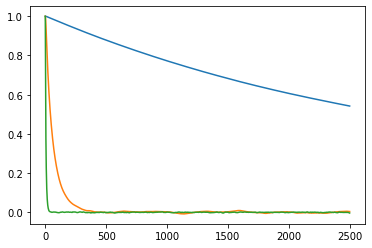

In [7]:
bps_first_component = autocorr(bps_samples[:,0], range(2500))
bps_second_component = autocorr(bps_samples[:,1], range(2500))
bps_third_component = autocorr(bps_samples[:,2], range(2500))

plt.plot(bps_first_component)
plt.plot(bps_second_component)
plt.plot(bps_third_component)

ESS_slow_bps = N/(1+2*sum(bps_first_component))
ESS_mid_bps = N/(1+2*sum(bps_second_component))
ESS_fast_bps = N/(1+2*sum(bps_third_component))
ESS_fast_bps_s, ESS_mid_bps_s, ESS_slow_bps_s = ESS_fast_bps/runtime_bps, ESS_mid_bps/runtime_bps, ESS_slow_bps/runtime_bps

# ZZ

In [8]:
# Implementing the Zig-Zag sampler

refreshment_rate = 1000000

x = start_point
v = np.random.choice([-1,1], no_dim)

Theta = 0.01
theta = 0.01

t = 0
T = 51000
i = 0
j = 0

no_samples = int(T/Theta)
zz_samples = np.zeros((no_samples, 3))

print('Started: ',str(time.ctime()))
start = time.time()
while t < T and i<no_samples:
    tau_refresh = np.random.exponential(size=1, scale=refreshment_rate)
    tau_reflect = np.random.exponential(size=no_dim, scale=beta**-1)
    dimension_reflection = np.argmin(tau_reflect)
    tau_reflect_true = tau_reflect[dimension_reflection]
    tau_event = np.min((tau_reflect_true, tau_refresh))
    j += 1
    
    if tau_event + t > Theta:
        # Time until Theta
        time_until_event = Theta - t

        # Update position
        x += time_until_event * v

        # Time until upper bounds fail to be valid
        t = Theta
        Theta +=theta

        zz_samples[i, :] = x
        i += 1
        
#         if np.round(t, 3) % 1 == 0:
#             progressBar(t, T) 
    else:
        if tau_refresh < tau_reflect_true:
            x += tau_refresh*v
            v = np.random.choice([-1,1], no_dim)
            t += tau_refresh
        else:
            x += tau_reflect_true*v

            gradient_at_reflection = grad_scale(x[dimension_reflection], scale=beta[dimension_reflection])

            if np.random.uniform(size=1) < np.max((0, -gradient_at_reflection*v[dimension_reflection])):
                v[dimension_reflection] = -v[dimension_reflection]

            t += tau_reflect[dimension_reflection]
            
end = time.time()

print('\nEnded: ',str(time.ctime()))
print("\nRuntime:", end-start)
runtime_zz = end-start
print("\nMean event time:", np.round(t/j, 4))

Started:  Wed Jan 20 22:59:28 2021

Ended:  Wed Jan 20 23:07:21 2021

Runtime: 473.3015458583832

Mean event time: 0.0047


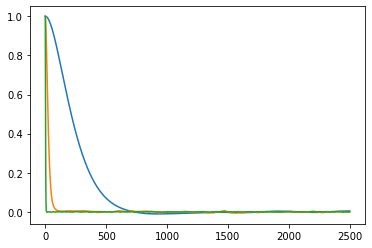

In [9]:
zz_first_component = autocorr(zz_samples[:,0], range(2500))
zz_second_component = autocorr(zz_samples[:,1], range(2500))
zz_third_component = autocorr(zz_samples[:,2], range(2500))

plt.plot(zz_first_component)
plt.plot(zz_second_component)
plt.plot(zz_third_component)

ESS_slow_zz = N/(1+2*sum(zz_first_component))
ESS_mid_zz = N/(1+2*sum(zz_second_component))
ESS_fast_zz = N/(1+2*sum(zz_third_component))
ESS_fast_zz_s, ESS_mid_zz_s, ESS_slow_zz_s = ESS_fast_zz/runtime_zz, ESS_mid_zz/runtime_zz, ESS_slow_zz/runtime_zz

In [10]:
probs = laplace_func_scale(zz_samples, beta)
prob_trace = np.sum(np.log(probs), axis=1)

ESS = (T/theta)/(1+2*sum(autocorr(prob_trace[10000:], range(2500))))
print("Effective Sample Size:", round(ESS))
print("Samples required to generate 1 independent sample:", round((T/theta)/ESS, 2))
print("ESS / s:", round(ESS/(end-start)))

Effective Sample Size: 889.0
Samples required to generate 1 independent sample: 5733.69
ESS / s: 2.0


# SK-ROCK

In [2]:
N = 23400000 # same as for MY-ULA and MY-UULA


s = 15 # s in {3, .., 15}
eta = 0.05
N = int(2*N/s)

skrock_samples = np.zeros((N,3))
x = start_point

# Parameters necessary for SK-ROCK
l = ((s-0.5)**2)*(2-4/(3*eta))-1.5
w_0 = 1+eta/(s**2)
T_poly = np.zeros(s+1)
T_poly[0] = 1
T_poly[1] = w_0
U_poly = np.zeros(s+1)
U_poly[0] = 1
U_poly[1] = 2*w_0
for i in range(2,s+1):
    T_poly[i] = 2*w_0*T_poly[i-1]-T_poly[i-2]
    U_poly[i] = 2*w_0*U_poly[i-1]-U_poly[i-2]
w_1 = T_poly[s]/(s*U_poly[s-1])

mu = np.zeros(s+1)
nu = np.zeros(s+1)
k = np.zeros(s+1)
mu[1] = w_1/w_0
nu[1] = s*w_1/2
k[1] = s*w_1/w_0
for i in range(2,s+1):
    mu[i] = 2*w_1*T_poly[i-1]/T_poly[i]
    nu[i] = 2*w_0*T_poly[i-1]/T_poly[i]
    k[i] = 1-nu[i]

K = np.zeros((no_dim,s+1))

# delta = 2*(10**(-2)) 

l_s = 40 # 1/sigma_max**2
delta = (w_0-1)/w_1/l_s # step size
delta

0.0012098469767066729

In [12]:
start = time.time()
print('Started: ',str(time.ctime()))
for i in range(N):
    
    Z = np.random.normal(size=no_dim)
    
    K[:,0] = x
    K[:,1] = x+mu[1]*delta*grad_prox(x+nu[1]*np.sqrt(2*delta)*Z)+k[1]*np.sqrt(2*delta)*Z
    for j in range(2,s+1):
        K[:,j] = mu[j]*delta*grad_prox(K[:,j-1])+nu[j]*K[:,j-1]+k[j]*K[:,j-2]
    x = K[:,s]

#     if (i+1)%100==0:
#         progressBar(i, N)    
    
    skrock_samples[i,:] = x
       
end = time.time()
print('\nEnded: ',str(time.ctime()))
print('Runtime:', end-start)
runtime_sk = end-start

Started:  Wed Jan 20 23:09:07 2021

Ended:  Wed Jan 20 23:17:29 2021
Runtime: 502.18701696395874


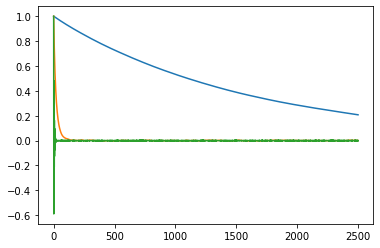

In [13]:
sk_first_component = autocorr(skrock_samples[:,0], range(2500))
sk_second_component = autocorr(skrock_samples[:,1], range(2500))
sk_third_component = autocorr(skrock_samples[:,2], range(2500))

plt.plot(sk_first_component)
plt.plot(sk_second_component)
plt.plot(sk_third_component)

ESS_slow_sk = N/(1+2*sum(sk_first_component))
ESS_mid_sk = N/(1+2*sum(sk_second_component))
ESS_fast_sk = N/(1+2*sum(sk_third_component))
ESS_fast_sk_s, ESS_mid_sk_s, ESS_slow_sk_s = ESS_fast_sk/runtime_sk, ESS_mid_sk/runtime_sk, ESS_slow_sk/runtime_sk

In [14]:
probs = laplace_func_scale(skrock_samples, beta)
prob_trace = np.prod(probs, axis=1)

ESS = N/(1+2*sum(autocorr(prob_trace[10000:], range(2500))))
print("Effective Sample Size:", round(ESS))
print("Samples required to generate 1 independent sample:", round(N/ESS, 2))
print("ESS / s:", round(ESS/(end-start)))

Effective Sample Size: 738.0
Samples required to generate 1 independent sample: 4228.01
ESS / s: 1.0


# p-MALA

In [15]:
N = 11000000
lamb_before = lamb
lamb = 0.00017

pmala_samples = np.zeros((N,3))
x = np.zeros(no_dim)
x = start_point

delta = lamb*2
mean = x+delta/2*grad_prox(x)
log_post = log_posterior(x)
accept = 0

In [16]:
start = time.time()
print('Started: ',str(time.ctime()))
for i in range(N):
    
    # Generate new proposal mean and variance
    proposal = mean+np.sqrt(delta)*np.random.normal(size=no_dim)
    mean_prop = proposal+delta/2*grad_prox(proposal)

#     if (i+1)%1000==0:
#         progressBar(i, N)    
        
    ''' Metropolis-Adjusted algorithm '''
    # Metropolis-Hastings
    log_post_prop = log_posterior(proposal)
    old_given_new = -0.5/(delta)*np.linalg.norm(x-mean_prop)**2
    new_given_old = -0.5/(delta)*np.linalg.norm(proposal-mean)**2
    mh_ratio = np.exp(log_post_prop-log_post + old_given_new-new_given_old) 

    if np.random.uniform() < mh_ratio:
        accept += 1
        mean = mean_prop
        log_post = log_post_prop
        x = proposal
    
    pmala_samples[i,:] = x
       
end = time.time()
print('\nEnded: ',str(time.ctime()))
print('\nAcceptance rate:', accept/(N-1)*100, '%')
print('Runtime:', end-start)
runtime_pm = end-start

lamb = lamb_before

Started:  Wed Jan 20 23:18:33 2021

Ended:  Wed Jan 20 23:26:47 2021

Acceptance rate: 65.19245138113195 %
Runtime: 494.32195496559143


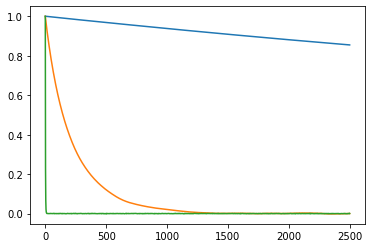

In [17]:
pm_first_component = autocorr(pmala_samples[:,0], range(2500))
pm_second_component = autocorr(pmala_samples[:,1], range(2500))
pm_third_component = autocorr(pmala_samples[:,2], range(2500))

plt.plot(pm_first_component)
plt.plot(pm_second_component)
plt.plot(pm_third_component)

ESS_slow_pm = N/(1+2*sum(pm_first_component))
ESS_mid_pm = N/(1+2*sum(pm_second_component))
ESS_fast_pm = N/(1+2*sum(pm_third_component))
ESS_fast_pm_s, ESS_mid_pm_s, ESS_slow_pm_s = ESS_fast_pm/runtime_pm, ESS_mid_pm/runtime_pm, ESS_slow_pm/runtime_pm

In [18]:
probs = laplace_func_scale(pmala_samples, beta)
prob_trace = np.prod(probs, axis=1)

ESS = N/(1+2*sum(autocorr(prob_trace[10000:], range(2500))))
print("Effective Sample Size:", round(ESS))
print("Samples required to generate 1 independent sample:", round(N/ESS, 2))
print("ESS / s:", round(ESS/(end-start)))

Effective Sample Size: 2362.0
Samples required to generate 1 independent sample: 4656.52
ESS / s: 5.0


# MY-ULA

In [19]:
N = 19200000


current_sample = np.zeros(no_dim)
proposed_sample = np.zeros(no_dim)

myula_samples = np.zeros((N*2,3))
current_sample = start_point

delta = lamb/4

start = time.time()
for i in np.arange(1, N*2):
    proposed_sample = current_sample+delta/2*grad_prox(current_sample) - np.sqrt(delta)*np.random.normal(size=no_dim)
    myula_samples[i,:] = proposed_sample
    current_sample = proposed_sample.copy()
#     if i % 1000 == 0:
#         progressBar(i+1,N*2) 
    
end = time.time()

print("\nRuntime:", end-start)
runtime_ula = end-start


Runtime: 494.9321458339691


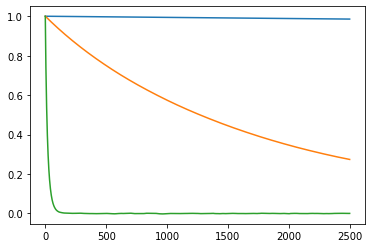

In [20]:
my_first_component = autocorr(myula_samples[:,0], range(2500))
my_second_component = autocorr(myula_samples[:,1], range(2500))
my_third_component = autocorr(myula_samples[:,2], range(2500))

plt.plot(my_first_component)
plt.plot(my_second_component)
plt.plot(my_third_component)

ESS_slow_my = N/(1+2*sum(my_first_component))
ESS_mid_my = N/(1+2*sum(my_second_component))
ESS_fast_my = N/(1+2*sum(my_third_component))
ESS_fast_my_s, ESS_mid_my_s, ESS_slow_my_s = ESS_fast_my/runtime_ula, ESS_mid_my/runtime_ula, ESS_slow_my/runtime_ula

In [21]:
probs = laplace_func_scale(myula_samples, beta)
prob_trace = np.prod(probs, axis=1)

ESS = N/(1+2*sum(autocorr(prob_trace[10000:], range(2500))))
print("Effective Sample Size:", round(ESS))
print("Samples required to generate 1 independent sample:", round(N/ESS, 2))
print("ESS / s:", round(ESS/(end-start)))

Effective Sample Size: 3776.0
Samples required to generate 1 independent sample: 5084.43
ESS / s: 8.0


# MY-UULA

In [22]:
N = 16600000

In [23]:
''' This is an implementation of the Unadjusted Underdamped Langevin Algorithm, as in [Cheng, Chatterji, 
Bartlett, Jordan 2018]. The proximal version targets the Moreau-Yosida envelope of the non-differentiable
distribution, and the proximal operator enters via the gradient, which is then replaced
by 1/eta*(prox_{eta}(x)-x). '''

def UULA_integration(theta_n,r_n):
    noise = np.matmul(U,Sigma_root*np.random.normal(size=2*no_dim))
    W_theta = noise[0:no_dim]
    W_r = noise[no_dim:2*no_dim]
    grad_theta = grad_prox(theta_n)
    theta_tau = theta_n+(1-beta_uula)/gamma*r_n  +  1/gamma*(nu-(1-beta_uula)/(gamma*xi))*grad_theta+W_theta
    r_tau = beta_uula*r_n  +  (1-beta_uula)/(gamma*xi)*grad_theta+W_r
    return np.append(theta_tau,r_tau)

In [24]:
L = 1/lamb # Lipschitz constant of the gradient
gamma = 2 # constant, describing the viscosity, fixed (to ensure convergence?)   gamma = 2 in paper by Ma, Chatterji, Cheng
xi = 2*L # constant, fixed (to ensure convergence?) 
nu = lamb/2 # step size of integrator, we set it to the same step size as the accuracy of the proximal operator
beta_uula = np.exp(-gamma*xi*nu) # arises after integrating the SDE

Sigma = np.zeros((2*no_dim,2*no_dim))
Sigma[0:no_dim,0:no_dim] = 1/gamma*(2*nu-3/(gamma*xi)+4/(gamma*xi)*beta_uula-1/(gamma*xi)*beta_uula**2)*np.eye(no_dim)
Sigma[no_dim:2*no_dim,0:no_dim] = (1+beta_uula**2-2*beta_uula)/(gamma*xi)*np.eye(no_dim)
Sigma[0:no_dim,no_dim:2*no_dim] = (1+beta_uula**2-2*beta_uula)/(gamma*xi)*np.eye(no_dim)
Sigma[no_dim:2*no_dim,no_dim:2*no_dim] = (1-beta_uula**2)/xi*np.eye(no_dim)
U,Sigma_evals,V_T = np.linalg.svd(Sigma)
Sigma_root = Sigma_evals**0.5

current_sample = np.zeros(2*no_dim)
proposed_sample = np.zeros(2*no_dim)

current_sample[0:no_dim] = start_point

myuula_samples = np.zeros((N,3))
#myuula_samples[0,0:no_dim] = start_point

start = time.time()
for i in np.arange(1, N):
    proposed_sample = UULA_integration(current_sample[0:no_dim], current_sample[no_dim:2*no_dim])
    myuula_samples[i,:] = proposed_sample[0:3] #UULA_integration(myuula_samples[i-1,0:no_dim],myuula_samples[i-1,no_dim:2*no_dim])
    current_sample = proposed_sample.copy()
    
#     if i % 1000 == 0:
#         progressBar(i+1,N) 
end = time.time()
print("\nRuntime:", end-start)
runtime_uula = end-start


Runtime: 509.31137108802795


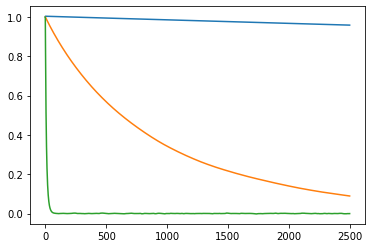

In [25]:
myu_first_component = autocorr(myuula_samples[:,0], range(2500))
myu_second_component = autocorr(myuula_samples[:,1], range(2500))
myu_third_component = autocorr(myuula_samples[:,2], range(2500))

plt.plot(myu_first_component)
plt.plot(myu_second_component)
plt.plot(myu_third_component)

ESS_slow_myu = N/(1+2*sum(myu_first_component))
ESS_mid_myu = N/(1+2*sum(myu_second_component))
ESS_fast_myu = N/(1+2*sum(myu_third_component))
ESS_fast_myu_s, ESS_mid_myu_s, ESS_slow_myu_s = ESS_fast_myu/runtime_uula, ESS_mid_myu/runtime_uula, ESS_slow_myu/runtime_uula

In [26]:
probs = laplace_func_scale(myuula_samples[:,0:no_dim], beta)
prob_trace = np.prod(probs, axis=1)

ESS = N/(1+2*sum(autocorr(prob_trace[10000:], range(2500))))
print("Effective Sample Size:", round(ESS))
print("Samples required to generate 1 independent sample:", round(N/ESS, 2))
print("ESS / s:", round(ESS/(end-start)))

Effective Sample Size: 3381.0
Samples required to generate 1 independent sample: 4910.0
ESS / s: 7.0


# Create plots

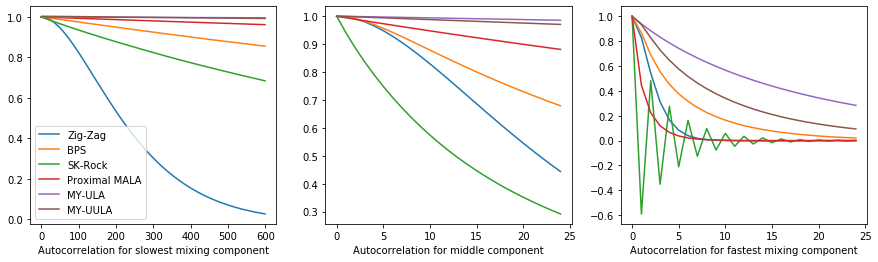

In [27]:
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(131)
ax1.plot(zz_first_component[:600], label="Zig-Zag")
ax1.plot(bps_first_component[:600], label="BPS")
ax1.plot(sk_first_component[:600], label="SK-Rock")
ax1.plot(pm_first_component[:600], label="Proximal MALA")
ax1.plot(my_first_component[:600], label="MY-ULA")
ax1.plot(myu_first_component[:600], label="MY-UULA")
ax1.set_xlabel("Autocorrelation for slowest mixing component")
ax1.legend()

ax2 = fig.add_subplot(132)
ax2.plot(zz_second_component[:25], label="Zig-Zag")
ax2.plot(bps_second_component[:25], label="BPS")
ax2.plot(sk_second_component[:25], label="SK-Rock")
ax2.plot(pm_second_component[:25], label="Proximal MALA")
ax2.plot(my_second_component[:25], label="MY-ULA")
ax2.plot(myu_second_component[:25], label="MY-UULA")
ax2.set_xlabel("Autocorrelation for middle component")

ax3 = fig.add_subplot(133)
ax3.plot(zz_third_component[:25], label="Zig-Zag")
ax3.plot(bps_third_component[:25], label="BPS")
ax3.plot(sk_third_component[:25], label="SK-Rock")
ax3.plot(pm_third_component[:25], label="Proximal MALA")
ax3.plot(my_third_component[:25], label="MY-ULA")
ax3.plot(myu_third_component[:25], label="MY-UULA")
ax3.set_xlabel("Autocorrelation for fastest mixing component")

plt.savefig("aniso_laplace_acf.pdf", dpi=150)
plt.show()

In [28]:
relative_fast = ESS_fast_my_s/ESS_fast_zz_s, ESS_fast_myu_s/ESS_fast_zz_s, ESS_fast_sk_s/ESS_fast_zz_s, ESS_fast_pm_s/ESS_fast_zz_s, ESS_fast_bps_s/ESS_fast_zz_s, ESS_fast_zz_s/ESS_fast_zz_s
absolute_fast = ESS_fast_my_s, ESS_fast_myu_s, ESS_fast_sk_s, ESS_fast_pm_s, ESS_fast_bps_s, ESS_fast_zz_s

relative_mid = ESS_mid_my_s/ESS_mid_zz_s, ESS_mid_myu_s/ESS_mid_zz_s, ESS_mid_sk_s/ESS_mid_zz_s, ESS_mid_pm_s/ESS_mid_zz_s, ESS_mid_bps_s/ESS_mid_zz_s, ESS_mid_zz_s/ESS_mid_zz_s
absolute_mid = ESS_mid_my_s, ESS_mid_myu_s, ESS_mid_sk_s, ESS_mid_pm_s, ESS_mid_bps_s, ESS_mid_zz_s

relative_slow = ESS_slow_my_s/ESS_slow_zz_s, ESS_slow_myu_s/ESS_slow_zz_s, ESS_slow_sk_s/ESS_slow_zz_s, ESS_slow_pm_s/ESS_slow_zz_s, ESS_slow_bps_s/ESS_slow_zz_s, ESS_slow_zz_s/ESS_slow_zz_s
absolute_slow = ESS_slow_my_s, ESS_slow_myu_s, ESS_slow_sk_s, ESS_slow_pm_s, ESS_slow_bps_s, ESS_slow_zz_s

print(relative_fast)
print(relative_mid)
print(relative_slow)
print(absolute_fast)
print(absolute_mid)
print(absolute_slow)

(0.6375934106215195, 0.9813898850021436, 1.7415447047967345, 3.0973568725730947, 0.5165544454866642, 1.0)
(0.07338243356905788, 0.09538783420734841, 0.7369503713340944, 0.2518000465662544, 0.38148051561036966, 1.0)
(0.354222211746682, 0.3010719529458294, 0.11184161039562485, 0.21812751348994389, 0.12360025685239637, 1.0)
(943.8796385385807, 1452.8285808635965, 2578.1455063344415, 4585.260820778327, 764.6961451753021, 1480.378596790228)
(14.191374945700693, 18.44698321732416, 142.518291194765, 48.69542611725744, 73.7742368057512, 193.38926573408935)
(7.813577557231431, 6.641167540141998, 2.4670477117816185, 4.8115453732149716, 2.726424715852029, 22.05840655418645)


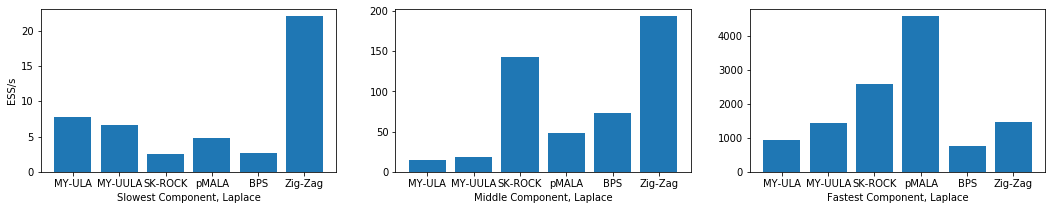

In [29]:
fig = plt.figure(figsize=(18,3))

ax1 = fig.add_subplot(131)
ax1.bar(["MY-ULA", "MY-UULA", "SK-ROCK", "pMALA", "BPS", "Zig-Zag"], absolute_slow)
ax1.set_ylabel("ESS/s")
ax1.set_xlabel("Slowest Component, Laplace")

ax2 = fig.add_subplot(132)
ax2.bar(["MY-ULA", "MY-UULA", "SK-ROCK", "pMALA", "BPS", "Zig-Zag"], absolute_mid)
ax2.set_xlabel("Middle Component, Laplace")

ax3 = fig.add_subplot(133)
ax3.bar(["MY-ULA", "MY-UULA", "SK-ROCK", "pMALA", "BPS", "Zig-Zag"], absolute_fast)
ax3.set_xlabel("Fastest Component, Laplace")

plt.savefig("aniso_laplace_slow_relative.pdf", dpi=300)

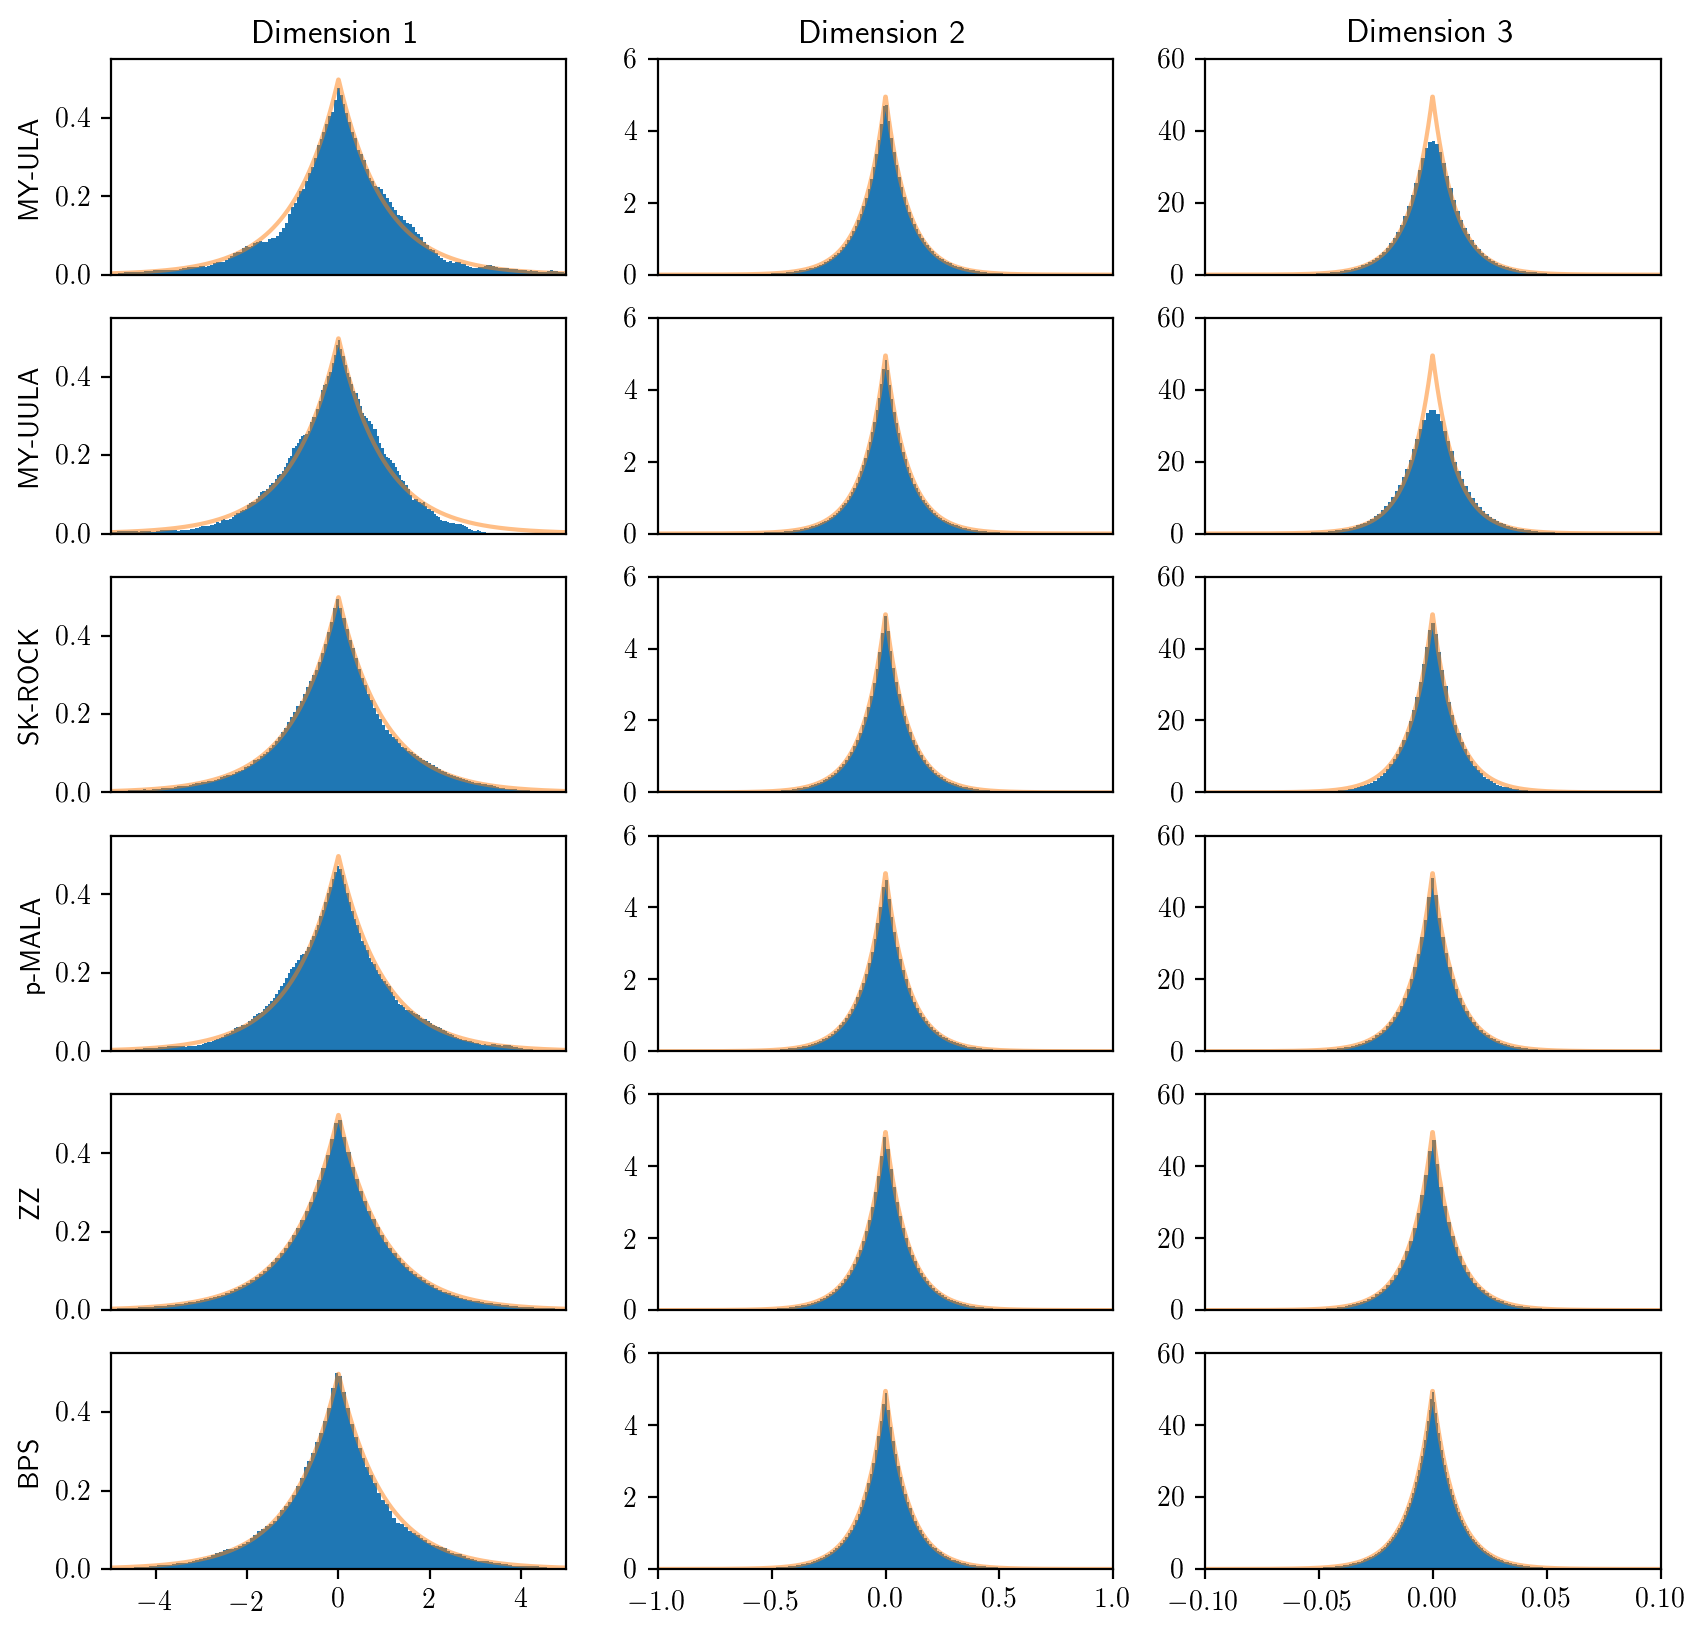

In [30]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(10, 10), dpi=200)
xvals_1 = np.linspace(-5,5,1000)
xvals_2 = np.linspace(-1,1,1000)
xvals_3 = np.linspace(-0.1,0.1,1000)



# MYULA

ax11 = fig.add_subplot(6,3,1)
n, bins, patches = ax11.hist(myula_samples[10000:, 0], bins=200, density=True)
ax11.plot(xvals_1, laplace_func_scale(xvals_1, scale=beta[0]), alpha = 0.5)
ax11.set_ylabel(r"MY-ULA")
ax11.set_ylim(0, 0.55)
ax11.set_xlim(-5, 5)
ax11.title.set_text("Dimension 1")
ax11.set_xticks([]) 

ax12 = fig.add_subplot(6,3,2)
n, bins, patches = ax12.hist(myula_samples[10000:, 1], bins=200, density=True)
ax12.plot(xvals_2, laplace_func_scale(xvals_2, scale=beta[1]), alpha = 0.5)
ax12.set_ylim(0, 6)
ax12.set_xlim(-1, 1)
ax12.title.set_text("Dimension 2")
ax12.set_xticks([]) 

ax13 = fig.add_subplot(6,3,3)
n, bins, patches = ax13.hist(myula_samples[10000:, 2], bins=200, density=True)
ax13.plot(xvals_3, laplace_func_scale(xvals_3, scale=beta[2]), alpha = 0.5)
ax13.set_ylim(0, 60)
ax13.set_xlim(-0.1, 0.1)
ax13.title.set_text("Dimension 3")
ax13.set_xticks([]) 


# MYUULA

ax21 = fig.add_subplot(6,3,4)
n, bins, patches = ax21.hist(myuula_samples[10000:, 0], bins=200, density=True)
ax21.plot(xvals_1, laplace_func_scale(xvals_1, scale=beta[0]), alpha = 0.5)
ax21.set_ylabel(r"MY-UULA")
ax21.set_ylim(0, 0.55)
ax21.set_xlim(-5, 5)
ax21.set_xticks([]) 

ax22 = fig.add_subplot(6,3,5)
n, bins, patches = ax22.hist(myuula_samples[10000:, 1], bins=200, density=True)
ax22.plot(xvals_2, laplace_func_scale(xvals_2, scale=beta[1]), alpha = 0.5)
ax22.set_ylim(0, 6)
ax22.set_xlim(-1, 1)
ax22.set_xticks([])  

ax23 = fig.add_subplot(6,3,6)
n, bins, patches = ax23.hist(myuula_samples[10000:, 2], bins=200, density=True)
ax23.plot(xvals_3, laplace_func_scale(xvals_3, scale=beta[2]), alpha = 0.5)
ax23.set_ylim(0, 60)
ax23.set_xlim(-0.1, 0.1)
ax23.set_xticks([]) 


# SK-ROCK

ax31 = fig.add_subplot(6,3,7)
n, bins, patches = ax31.hist(skrock_samples[10000:, 0], bins=200, density=True)
ax31.plot(xvals_1, laplace_func_scale(xvals_1, scale=beta[0]), alpha = 0.5)
ax31.set_ylabel(r"SK-ROCK")
ax31.set_ylim(0, 0.55)
ax31.set_xlim(-5, 5)
ax31.set_xticks([]) 

ax32 = fig.add_subplot(6,3,8)
n, bins, patches = ax32.hist(skrock_samples[10000:, 1], bins=200, density=True)
ax32.plot(xvals_2, laplace_func_scale(xvals_2, scale=beta[1]), alpha = 0.5)
ax32.set_ylim(0, 6)
ax32.set_xlim(-1, 1)
ax32.set_xticks([]) 

ax33 = fig.add_subplot(6,3,9)
n, bins, patches = ax33.hist(skrock_samples[10000:, 2], bins=200, density=True)
ax33.plot(xvals_3, laplace_func_scale(xvals_3, scale=beta[2]), alpha = 0.5)
ax33.set_ylim(0, 60)
ax33.set_xlim(-0.1, 0.1)
ax33.set_xticks([]) 


# pMALA

ax41 = fig.add_subplot(6,3,10)
n, bins, patches = ax41.hist(pmala_samples[10000:, 0], bins=200, density=True)
ax41.plot(xvals_1, laplace_func_scale(xvals_1, scale=beta[0]), alpha = 0.5)
ax41.set_ylabel(r"p-MALA")
ax41.set_ylim(0, 0.55)
ax41.set_xlim(-5, 5)
ax41.set_xticks([]) 

ax42 = fig.add_subplot(6,3,11)
n, bins, patches = ax42.hist(pmala_samples[10000:, 1], bins=200, density=True)
ax42.plot(xvals_2, laplace_func_scale(xvals_2, scale=beta[1]), alpha = 0.5)
ax42.set_ylim(0, 6)
ax42.set_xlim(-1, 1)
ax42.set_xticks([]) 

ax43 = fig.add_subplot(6,3,12)
n, bins, patches = ax43.hist(pmala_samples[10000:, 2], bins=200, density=True)
ax43.plot(xvals_3, laplace_func_scale(xvals_3, scale=beta[2]), alpha = 0.5)
ax43.set_ylim(0, 60)
ax43.set_xlim(-0.1, 0.1)
ax43.set_xticks([]) 



# ZZ

ax51 = fig.add_subplot(6,3,13)
n, bins, patches = ax51.hist(zz_samples[10000:, 0], bins=200, density=True)
ax51.plot(xvals_1, laplace_func_scale(xvals_1, scale=beta[0]), alpha = 0.5)
ax51.set_ylabel("ZZ")
ax51.set_ylim(0, 0.55)
ax51.set_xlim(-5, 5)
ax51.set_xticks([]) 

ax52 = fig.add_subplot(6,3,14)
n, bins, patches = ax52.hist(zz_samples[10000:, 1], bins=200, density=True)
ax52.plot(xvals_2, laplace_func_scale(xvals_2, scale=beta[1]), alpha = 0.5)
ax52.set_ylim(0, 6)
ax52.set_xlim(-1, 1)
ax52.set_xticks([]) 

ax53 = fig.add_subplot(6,3,15)
n, bins, patches = ax53.hist(zz_samples[10000:, 2], bins=200, density=True)
ax53.plot(xvals_3, laplace_func_scale(xvals_3, scale=beta[2]), alpha = 0.5)
ax53.set_ylim(0, 60)
ax53.set_xlim(-0.1, 0.1)
ax53.set_xticks([]) 


# BPS

ax61 = fig.add_subplot(6,3,16)
n, bins, patches = ax61.hist(bps_samples[10000:, 0], bins=200, density=True)
ax61.plot(xvals_1, laplace_func_scale(xvals_1, scale=beta[0]), alpha = 0.5)
ax61.set_ylabel("BPS")
ax61.set_ylim(0, 0.55)
ax61.set_xlim(-5, 5)

ax62 = fig.add_subplot(6,3,17)
n, bins, patches = ax62.hist(bps_samples[10000:, 1], bins=200, density=True)
ax62.plot(xvals_2, laplace_func_scale(xvals_2, scale=beta[1]), alpha = 0.5)
ax62.set_ylim(0, 6)
ax62.set_xlim(-1, 1)

ax63 = fig.add_subplot(6,3,18)
n, bins, patches = ax63.hist(bps_samples[10000:, 2], bins=400, density=True)
ax63.plot(xvals_3, laplace_func_scale(xvals_3, scale=beta[2]), alpha = 0.5)
ax63.set_ylim(0, 60)
ax63.set_xlim(-0.1, 0.1)



plt.savefig("aniso_Laplace_3D.pdf", dpi=300, bbox_inches='tight')